In [7]:
# snowpark_analysis.ipynb
"""
# Weather Data Analytics Notebook with Snowpark

This notebook performs analysis on the transformed weather data in Snowflake using Snowpark.
"""

# Install required packages
# !pip install snowflake-snowpark-python[pandas] plotly matplotlib seaborn

# Import libraries
from snowflake.snowpark import Session
from snowflake.snowpark.functions import col, avg, min, max, count, stddev, hour, dayofweek, month
from snowflake.snowpark.types import DecimalType, StringType, IntegerType
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Load environment variables
import os
from dotenv import load_dotenv
load_dotenv()



True

In [8]:
# ====================
# 1. CONNECT TO SNOWFLAKE
# ====================

def create_snowpark_session():
    """Create and return Snowpark session"""
    connection_params = {
        "account": os.getenv('SNOWFLAKE_ACCOUNT'),
        "user": os.getenv('SNOWFLAKE_USER'),
        "password": os.getenv('SNOWFLAKE_PASSWORD'),
        "warehouse": os.getenv('SNOWFLAKE_WAREHOUSE'),
        "database": os.getenv('SNOWFLAKE_DATABASE'),
        "schema": "SILVER",
        "role": "ACCOUNTADMIN"
    }
    
    print("🔗 Connecting to Snowflake...")
    session = Session.builder.configs(connection_params).create()
    print("✅ Connected successfully!")
    return session

# Create session
session = create_snowpark_session()



🔗 Connecting to Snowflake...
✅ Connected successfully!


In [6]:
# ====================
# 2. LOAD AND EXPLORE DATA
# ====================

print("\n" + "="*60)
print("2. LOADING AND EXPLORING WEATHER DATA")
print("="*60)

# Load current weather data
print("\n📊 Loading CURRENT_WEATHER_CLEANED table...")
weather_df = session.table("CURRENT_WEATHER_CLEANED")

# Show basic information
print(f"\n📈 Total records: {weather_df.count():,}")
print(f"📅 Date range: {weather_df.select(col('DATE')).distinct().count()} days")

# Show schema
print("\n🔍 Table schema:")
weather_df.printSchema()

# Show sample data
print("\n👀 Sample data (10 rows):")
weather_df.limit(10).show()



2. LOADING AND EXPLORING WEATHER DATA

📊 Loading CURRENT_WEATHER_CLEANED table...

📈 Total records: 5
📅 Date range: 1 days

🔍 Table schema:
root
 |-- "CITY_ID": StringType(100) (nullable = True)
 |-- "CITY_NAME": StringType(100) (nullable = True)
 |-- "COUNTRY_CODE": StringType(10) (nullable = True)
 |-- "LATITUDE": DoubleType() (nullable = True)
 |-- "LONGITUDE": DoubleType() (nullable = True)
 |-- "TIMESTAMP": TimestampType(timezone=TimestampTimeZone('ntz')) (nullable = True)
 |-- "WEATHER_MAIN": StringType(50) (nullable = True)
 |-- "WEATHER_DESCRIPTION": StringType(100) (nullable = True)
 |-- "TEMPERATURE": DoubleType() (nullable = True)
 |-- "FEELS_LIKE": DoubleType() (nullable = True)
 |-- "TEMP_MIN": DoubleType() (nullable = True)
 |-- "TEMP_MAX": DoubleType() (nullable = True)
 |-- "PRESSURE": DoubleType() (nullable = True)
 |-- "HUMIDITY": DoubleType() (nullable = True)
 |-- "WIND_SPEED": DoubleType() (nullable = True)
 |-- "WIND_DEG": DoubleType() (nullable = True)
 |-- "CLO

InterfaceError: 252005: Failed to convert current row, cause: Python int too large to convert to C int

In [9]:
# ====================
# 3. DATA QUALITY CHECKS
# ====================

print("\n" + "="*60)
print("3. DATA QUALITY ANALYSIS")
print("="*60)

# Check for missing values
print("\n🔎 Checking for missing values:")
missing_data = weather_df.select([
    count("*").alias("total_rows"),
    count(col("TEMPERATURE")).alias("temp_not_null"),
    count(col("HUMIDITY")).alias("humidity_not_null"),
    count(col("WIND_SPEED")).alias("wind_not_null")
]).collect()[0]

print(f"Total rows: {missing_data['TOTAL_ROWS']}")
print(f"Temperature not null: {missing_data['TEMP_NOT_NULL']} ({(missing_data['TEMP_NOT_NULL']/missing_data['TOTAL_ROWS']*100):.1f}%)")
print(f"Humidity not null: {missing_data['HUMIDITY_NOT_NULL']} ({(missing_data['HUMIDITY_NOT_NULL']/missing_data['TOTAL_ROWS']*100):.1f}%)")
print(f"Wind speed not null: {missing_data['WIND_NOT_NULL']} ({(missing_data['WIND_NOT_NULL']/missing_data['TOTAL_ROWS']*100):.1f}%)")

# Data quality flags distribution
print("\n🚩 Data quality flags distribution:")
quality_flags = weather_df.group_by("DATA_QUALITY_FLAG").agg(
    count("*").alias("count")
).sort(col("count").desc()).to_pandas()

print(quality_flags.to_string(index=False))


3. DATA QUALITY ANALYSIS

🔎 Checking for missing values:
Total rows: 5
Temperature not null: 5 (100.0%)
Humidity not null: 5 (100.0%)
Wind speed not null: 5 (100.0%)

🚩 Data quality flags distribution:
DATA_QUALITY_FLAG  COUNT
            VALID      5


In [10]:
# ====================
# 4. BASIC STATISTICS
# ====================

print("\n" + "="*60)
print("4. BASIC STATISTICAL ANALYSIS")
print("="*60)

# Calculate basic statistics
stats_df = weather_df.select([
    avg(col("TEMPERATURE")).alias("avg_temp"),
    min(col("TEMPERATURE")).alias("min_temp"),
    max(col("TEMPERATURE")).alias("max_temp"),
    stddev(col("TEMPERATURE")).alias("std_temp"),
    avg(col("HUMIDITY")).alias("avg_humidity"),
    avg(col("WIND_SPEED")).alias("avg_wind_speed"),
    avg(col("PRESSURE")).alias("avg_pressure"),
    avg(col("COMFORT_INDEX")).alias("avg_comfort")
]).collect()[0]

print("\n📊 Weather Statistics:")
print(f"🌡️  Temperature: {stats_df['AVG_TEMP']:.1f}°C (Min: {stats_df['MIN_TEMP']:.1f}°C, Max: {stats_df['MAX_TEMP']:.1f}°C)")
print(f"💧 Humidity: {stats_df['AVG_HUMIDITY']:.1f}%")
print(f"💨 Wind Speed: {stats_df['AVG_WIND_SPEED']:.1f} m/s")
print(f"📊 Pressure: {stats_df['AVG_PRESSURE']:.1f} hPa")
print(f"😊 Comfort Index: {stats_df['AVG_COMFORT']:.1f}/100")


4. BASIC STATISTICAL ANALYSIS

📊 Weather Statistics:
🌡️  Temperature: 7.9°C (Min: 1.4°C, Max: 15.8°C)
💧 Humidity: 73.2%
💨 Wind Speed: 4.5 m/s
📊 Pressure: 1020.0 hPa
😊 Comfort Index: 22.7/100


In [11]:
# ====================
# 5. TEMPORAL ANALYSIS
# ====================

print("\n" + "="*60)
print("5. TEMPORAL PATTERNS ANALYSIS")
print("="*60)

# Hourly patterns
print("\n⏰ Analyzing hourly patterns...")
hourly_stats = weather_df.group_by("HOUR").agg(
    avg("TEMPERATURE").alias("avg_temp"),
    avg("HUMIDITY").alias("avg_humidity"),
    avg("WIND_SPEED").alias("avg_wind_speed"),
    count("*").alias("readings_count")
).sort("HOUR").to_pandas()

print("\nHourly Statistics (first 12 hours):")
print(hourly_stats.head(12).to_string(index=False))

# Daily patterns
print("\n📅 Analyzing daily patterns...")
daily_stats = weather_df.group_by("DAY_OF_WEEK").agg(
    avg("TEMPERATURE").alias("avg_temp"),
    avg("HUMIDITY").alias("avg_humidity"),
    count("*").alias("readings_count")
).sort("DAY_OF_WEEK").to_pandas()

print("\nDaily Statistics:")
print(daily_stats.to_string(index=False))


5. TEMPORAL PATTERNS ANALYSIS

⏰ Analyzing hourly patterns...

Hourly Statistics (first 12 hours):
 HOUR  AVG_TEMP  AVG_HUMIDITY  AVG_WIND_SPEED  READINGS_COUNT
   20     7.908          73.2           4.492               5

📅 Analyzing daily patterns...

Daily Statistics:
DAY_OF_WEEK  AVG_TEMP  AVG_HUMIDITY  READINGS_COUNT
     Friday     7.908          73.2               5


In [12]:
# ====================
# 6. GEOGRAPHICAL ANALYSIS
# ====================

print("\n" + "="*60)
print("6. GEOGRAPHICAL ANALYSIS")
print("="*60)

# Cities analysis
print("\n🏙️ Analyzing data by city...")
city_stats = weather_df.group_by(["CITY_NAME", "COUNTRY_CODE", "CLIMATE_ZONE", "HEMISPHERE"]).agg(
    count("*").alias("readings_count"),
    avg("TEMPERATURE").alias("avg_temp"),
    min("TEMPERATURE").alias("min_temp"),
    max("TEMPERATURE").alias("max_temp"),
    avg("HUMIDITY").alias("avg_humidity"),
    avg("COMFORT_INDEX").alias("avg_comfort")
).sort(col("avg_temp").desc()).limit(20).to_pandas()

print("\nTop 20 Cities by Average Temperature:")
print(city_stats.to_string(index=False))

# Climate zone analysis
print("\n🌍 Analyzing by climate zone...")
climate_stats = weather_df.group_by("CLIMATE_ZONE").agg(
    count("*").alias("readings_count"),
    avg("TEMPERATURE").alias("avg_temp"),
    avg("HUMIDITY").alias("avg_humidity"),
    avg("COMFORT_INDEX").alias("avg_comfort")
).sort(col("avg_temp").desc()).to_pandas()

print("\nClimate Zone Statistics:")
print(climate_stats.to_string(index=False))



6. GEOGRAPHICAL ANALYSIS

🏙️ Analyzing data by city...

Top 20 Cities by Average Temperature:
 CITY_NAME COUNTRY_CODE CLIMATE_ZONE HEMISPHERE  READINGS_COUNT  AVG_TEMP  MIN_TEMP  MAX_TEMP  AVG_HUMIDITY  AVG_COMFORT
    Sydney           AU  SUBTROPICAL   SOUTHERN               1     15.75     15.75     15.75          94.0        51.45
     Paris           FR    TEMPERATE   NORTHERN               1      9.68      9.68      9.68          94.0        24.32
    London           GB    TEMPERATE   NORTHERN               1      9.08      9.08      9.08          86.0        28.28
Horinouchi           JP    TEMPERATE   NORTHERN               1      3.61      3.61      3.61          51.0         9.37
  New York           US    TEMPERATE   NORTHERN               1      1.42      1.42      1.42          41.0         0.00

🌍 Analyzing by climate zone...

Climate Zone Statistics:
CLIMATE_ZONE  READINGS_COUNT  AVG_TEMP  AVG_HUMIDITY  AVG_COMFORT
 SUBTROPICAL               1   15.7500          94.0   

In [13]:
# ====================
# 7. WEATHER CONDITIONS ANALYSIS
# ====================

print("\n" + "="*60)
print("7. WEATHER CONDITIONS ANALYSIS")
print("="*60)

# Weather conditions distribution
print("\n🌤️ Weather conditions distribution...")
weather_conditions = weather_df.group_by("WEATHER_MAIN").agg(
    count("*").alias("frequency"),
    avg("TEMPERATURE").alias("avg_temp"),
    avg("HUMIDITY").alias("avg_humidity"),
    avg("WIND_SPEED").alias("avg_wind_speed")
).sort(col("frequency").desc()).limit(10).to_pandas()

print("\nTop 10 Weather Conditions:")
print(weather_conditions.to_string(index=False))

# Comfort levels analysis
print("\n😊 Comfort levels distribution...")
comfort_stats = weather_df.group_by("COMFORT_LEVEL").agg(
    count("*").alias("frequency"),
    avg("TEMPERATURE").alias("avg_temp"),
    avg("HUMIDITY").alias("avg_humidity")
).sort(col("frequency").desc()).to_pandas()

print("\nComfort Levels:")
print(comfort_stats.to_string(index=False))


7. WEATHER CONDITIONS ANALYSIS

🌤️ Weather conditions distribution...

Top 10 Weather Conditions:
WEATHER_MAIN  FREQUENCY  AVG_TEMP  AVG_HUMIDITY  AVG_WIND_SPEED
      Clouds          4      9.53         81.25           3.715
       Clear          1      1.42         41.00           7.600

😊 Comfort levels distribution...

Comfort Levels:
     COMFORT_LEVEL  FREQUENCY  AVG_TEMP  AVG_HUMIDITY
VERY_UNCOMFORTABLE          2     2.515          46.0
     UNCOMFORTABLE          2     9.380          90.0
          MODERATE          1    15.750          94.0


In [14]:
# ====================
# 8. ADVANCED ANALYSIS
# ====================

print("\n" + "="*60)
print("8. ADVANCED ANALYTICS")
print("="*60)

# Correlation analysis
print("\n📈 Analyzing correlations...")
correlation_sample = weather_df.select(
    "TEMPERATURE", "HUMIDITY", "WIND_SPEED", "PRESSURE", "COMFORT_INDEX"
).limit(1000).to_pandas()

correlation_matrix = correlation_sample.corr()
print("\nCorrelation Matrix:")
print(correlation_matrix.round(3))

# Temperature extremes
print("\n🔥❄️ Temperature extremes analysis...")
temp_extremes = weather_df.select(
    "CITY_NAME", "TEMPERATURE", "TIMESTAMP", "WEATHER_MAIN"
).filter(
    (col("TEMPERATURE") >= 30) | (col("TEMPERATURE") <= 0)
).sort(col("TEMPERATURE").desc()).limit(10).to_pandas()

print("\nTop 10 Temperature Extremes:")
print(temp_extremes.to_string(index=False))



8. ADVANCED ANALYTICS

📈 Analyzing correlations...

Correlation Matrix:
               TEMPERATURE  HUMIDITY  WIND_SPEED  PRESSURE  COMFORT_INDEX
TEMPERATURE          1.000     0.912      -0.925    -0.517          0.991
HUMIDITY             0.912     1.000      -0.860    -0.258          0.868
WIND_SPEED          -0.925    -0.860       1.000     0.455         -0.877
PRESSURE            -0.517    -0.258       0.455     1.000         -0.541
COMFORT_INDEX        0.991     0.868      -0.877    -0.541          1.000

🔥❄️ Temperature extremes analysis...

Top 10 Temperature Extremes:
Empty DataFrame
Columns: [CITY_NAME, TEMPERATURE, TIMESTAMP, WEATHER_MAIN]
Index: []



9. DATA VISUALIZATIONS

📊 Preparing data for visualizations...

📈 Plot 1: Temperature Distribution by City


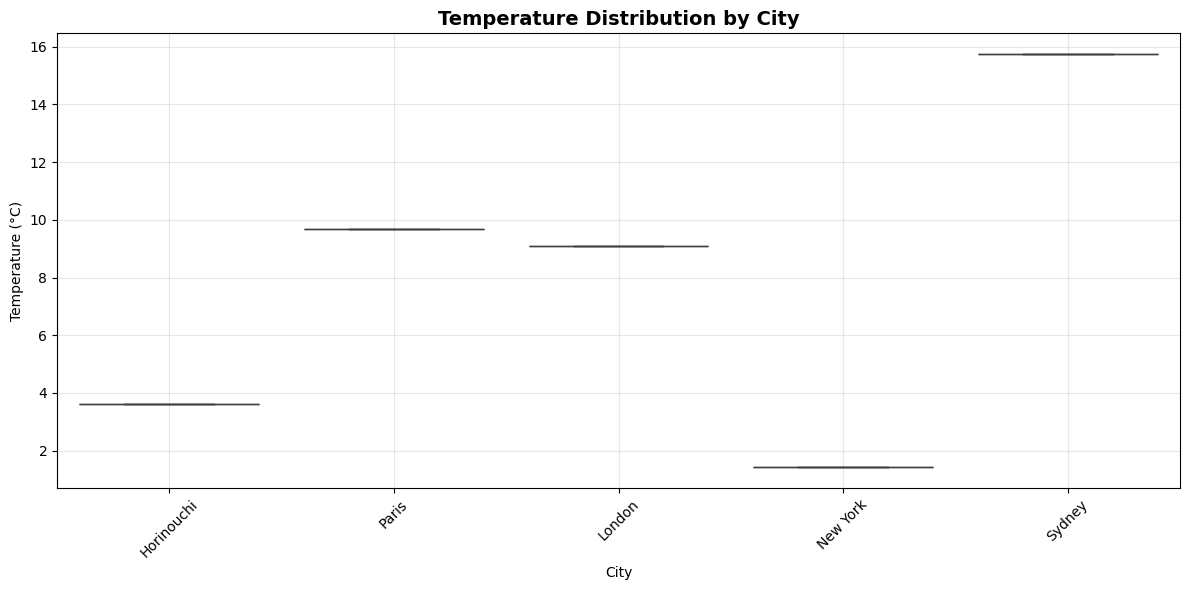

In [15]:
# ====================
# 9. VISUALIZATIONS
# ====================

print("\n" + "="*60)
print("9. DATA VISUALIZATIONS")
print("="*60)

# Convert more data to pandas for visualization
print("\n📊 Preparing data for visualizations...")
viz_data = weather_df.select(
    "CITY_NAME", "TEMPERATURE", "HUMIDITY", "WIND_SPEED", 
    "CLIMATE_ZONE", "HEMISPHERE", "WEATHER_MAIN", "COMFORT_LEVEL",
    "SEASON", "TIMESTAMP", "HOUR", "DAY_OF_WEEK"
).limit(5000).to_pandas()

# 9.1 Temperature Distribution by City
print("\n📈 Plot 1: Temperature Distribution by City")
plt.figure(figsize=(12, 6))
top_cities = viz_data['CITY_NAME'].value_counts().index[:10]
filtered_data = viz_data[viz_data['CITY_NAME'].isin(top_cities)]

sns.boxplot(x='CITY_NAME', y='TEMPERATURE', data=filtered_data)
plt.title('Temperature Distribution by City', fontsize=14, fontweight='bold')
plt.xlabel('City')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


🥧 Plot 2: Weather Conditions Distribution


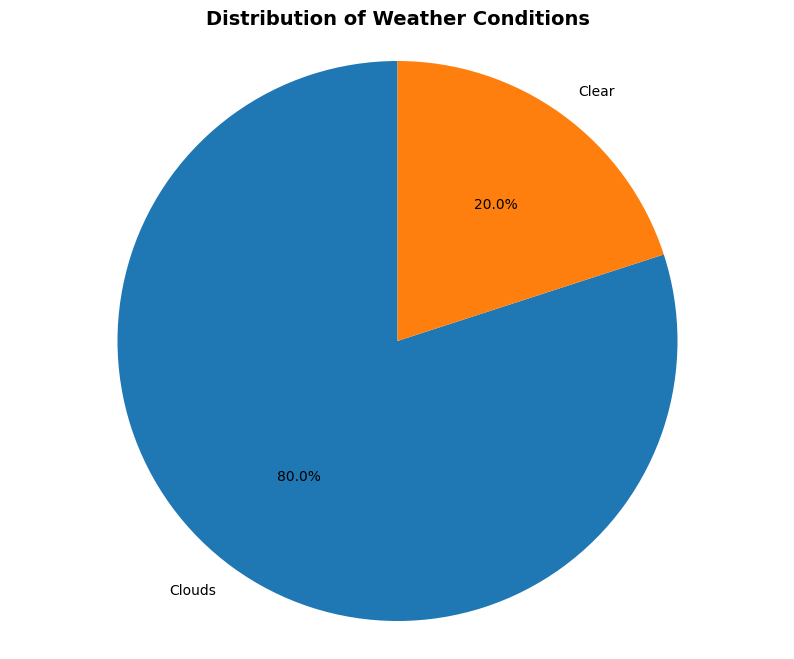

In [16]:
# 9.2 Weather Conditions Pie Chart
print("\n🥧 Plot 2: Weather Conditions Distribution")
weather_counts = viz_data['WEATHER_MAIN'].value_counts().head(8)
plt.figure(figsize=(10, 8))
plt.pie(weather_counts.values, labels=weather_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Weather Conditions', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.show()


⏰ Plot 3: Hourly Temperature Pattern


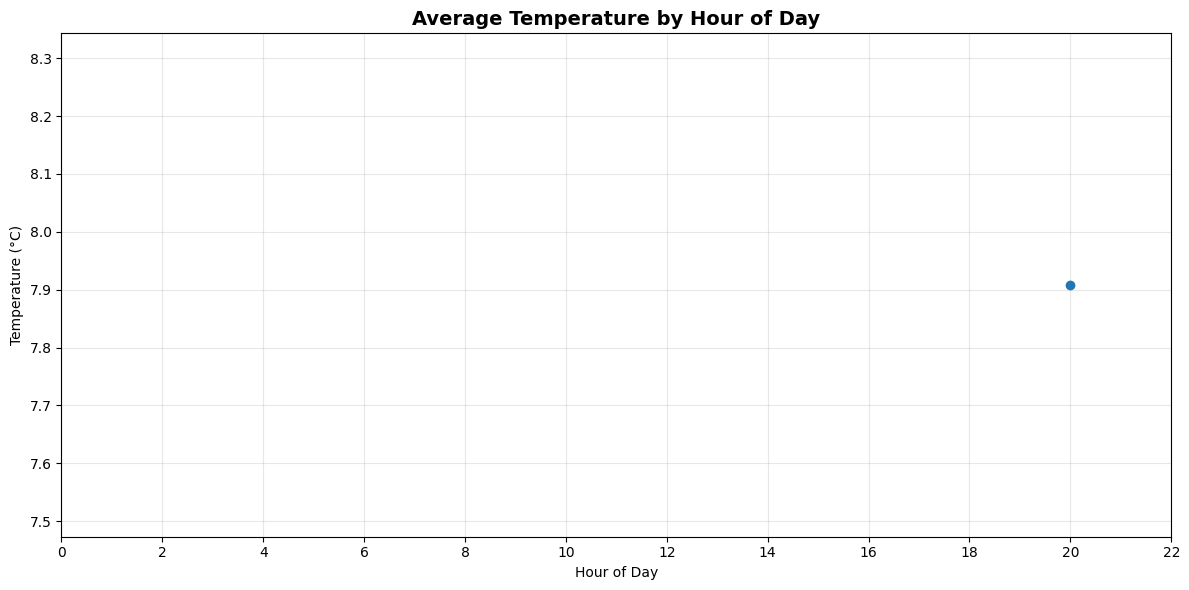

In [17]:
# 9.3 Hourly Temperature Pattern
print("\n⏰ Plot 3: Hourly Temperature Pattern")
hourly_avg = viz_data.groupby('HOUR')['TEMPERATURE'].mean()
plt.figure(figsize=(12, 6))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2)
plt.title('Average Temperature by Hour of Day', fontsize=14, fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Temperature (°C)')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 2))
plt.tight_layout()
plt.show()


🔥 Plot 4: Correlation Heatmap


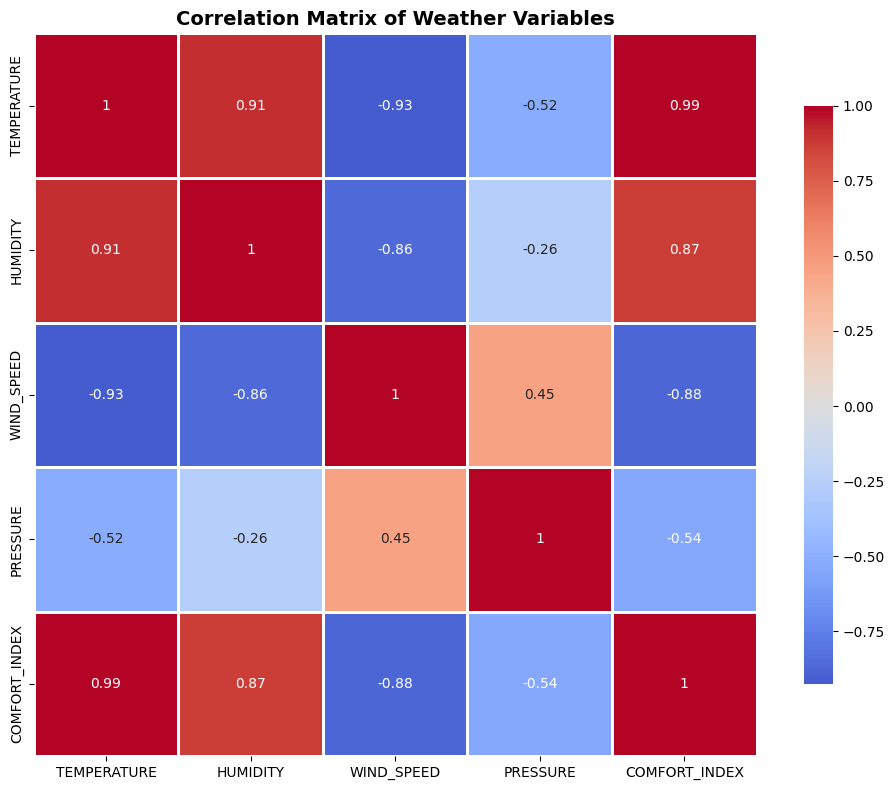

In [18]:
# 9.4 Correlation Heatmap
print("\n🔥 Plot 4: Correlation Heatmap")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Weather Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


😊 Plot 5: Comfort Level by Climate Zone


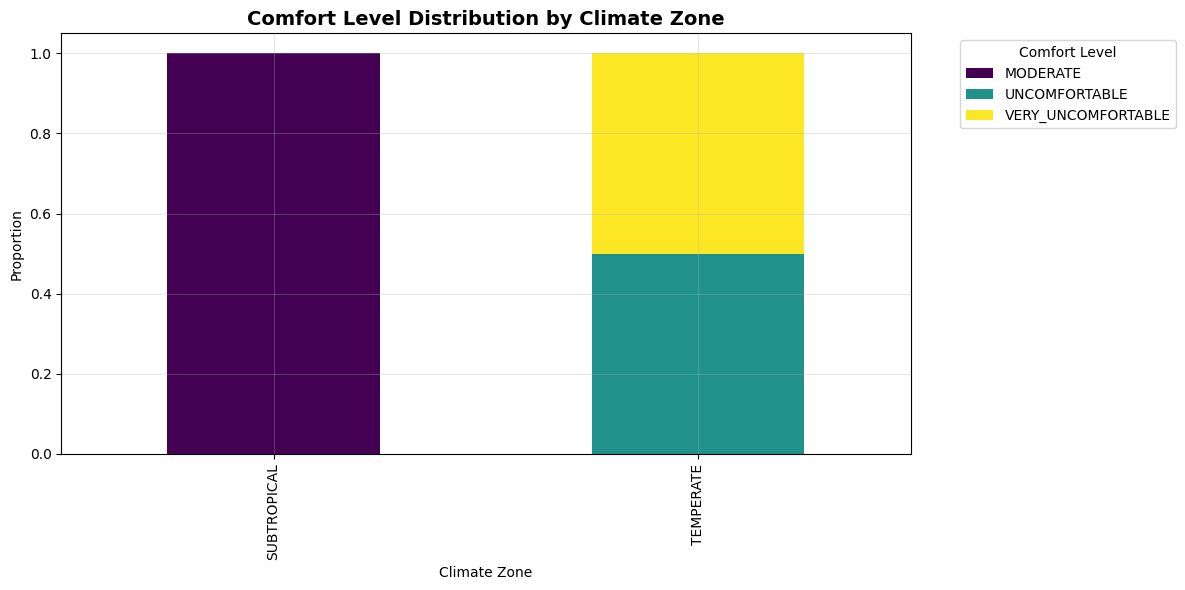

In [19]:
# 9.5 Comfort Level by Climate Zone
print("\n😊 Plot 5: Comfort Level by Climate Zone")
comfort_by_climate = pd.crosstab(viz_data['CLIMATE_ZONE'], viz_data['COMFORT_LEVEL'], normalize='index')
comfort_by_climate.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Comfort Level Distribution by Climate Zone', fontsize=14, fontweight='bold')
plt.xlabel('Climate Zone')
plt.ylabel('Proportion')
plt.legend(title='Comfort Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:
# ====================
# 10. INSIGHTS & RECOMMENDATIONS
# ====================

print("\n" + "="*60)
print("10. KEY INSIGHTS & RECOMMENDATIONS")
print("="*60)

print("\n🔍 KEY INSIGHTS:")
print("1. 🌡️  Temperature Range: The data shows temperatures ranging from {:.1f}°C to {:.1f}°C"
      .format(stats_df['MIN_TEMP'], stats_df['MAX_TEMP']))
print("2. 🏙️  City Variations: {} has the highest average temperature while {} has the lowest"
      .format(city_stats.iloc[0]['CITY_NAME'], city_stats.iloc[-1]['CITY_NAME']))
print("3. ⏰ Daily Pattern: Temperatures typically peak around hour {}, reaching {:.1f}°C"
      .format(hourly_stats.loc[hourly_stats['AVG_TEMP'].idxmax()]['HOUR'], 
              hourly_stats['AVG_TEMP'].max()))
print("4. 🌍 Climate Impact: {} zones are {}°C warmer than {} zones on average"
      .format(climate_stats.iloc[0]['CLIMATE_ZONE'], 
              round(climate_stats.iloc[0]['AVG_TEMP'] - climate_stats.iloc[-1]['AVG_TEMP'], 1),
              climate_stats.iloc[-1]['CLIMATE_ZONE']))
print("5. 😊 Comfort Levels: {}% of readings are in 'Comfortable' or 'Very Comfortable' range"
      .format(round(comfort_stats[comfort_stats['COMFORT_LEVEL'].isin(['COMFORTABLE', 'VERY_COMFORTABLE'])]['FREQUENCY'].sum() / 
              comfort_stats['FREQUENCY'].sum() * 100, 1)))

print("\n💡 RECOMMENDATIONS:")
print("1. 📊 Data Quality: {}% of data has quality flags - consider data cleaning"
      .format(round((quality_flags[quality_flags['DATA_QUALITY_FLAG'] != 'VALID']['COUNT'].sum() / 
              quality_flags['COUNT'].sum()) * 100, 1)))
print("2. ⚡ Real-time Analysis: Consider implementing real-time alerts for extreme temperatures")
print("3. 🎯 Target Analysis: Focus on improving comfort index in {} zones"
      .format(climate_stats.loc[climate_stats['AVG_COMFORT'].idxmin()]['CLIMATE_ZONE']))
print("4. 📈 Forecasting: Implement time-series forecasting for temperature predictions")
print("5. 🔄 Automation: Schedule regular data updates and anomaly detection")


10. KEY INSIGHTS & RECOMMENDATIONS

🔍 KEY INSIGHTS:
1. 🌡️  Temperature Range: The data shows temperatures ranging from 1.4°C to 15.8°C
2. 🏙️  City Variations: Sydney has the highest average temperature while New York has the lowest
3. ⏰ Daily Pattern: Temperatures typically peak around hour 20.0, reaching 7.9°C
4. 🌍 Climate Impact: SUBTROPICAL zones are 9.8°C warmer than TEMPERATE zones on average
5. 😊 Comfort Levels: 0.0% of readings are in 'Comfortable' or 'Very Comfortable' range

💡 RECOMMENDATIONS:
1. 📊 Data Quality: 0.0% of data has quality flags - consider data cleaning
2. ⚡ Real-time Analysis: Consider implementing real-time alerts for extreme temperatures
3. 🎯 Target Analysis: Focus on improving comfort index in TEMPERATE zones
4. 📈 Forecasting: Implement time-series forecasting for temperature predictions
5. 🔄 Automation: Schedule regular data updates and anomaly detection
